<font size="6">**Kaggle Test Using TensorFlow and Convolutional NN**</font>

Data is available in https://www.kaggle.com/c/digit-recognizer/data

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import math as math
import time

import numpy as np # linear algebra
import tensorflow as tf

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

print("TensorFlow Version:",tf.__version__)
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

TensorFlow Version: 1.13.1


In [2]:
path = os.listdir("../../data/digit-recognizer")
print(path)

# Read the data
train_data = pd.read_csv('../../data/digit-recognizer/train.csv')
test_data = pd.read_csv("../../data/digit-recognizer/test.csv")

# Set up the data
y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values/255

# Test Data
X_test_public = test_data.values/255

print(X_test_public.shape)

['test.csv', 'train.csv']
(28000, 784)


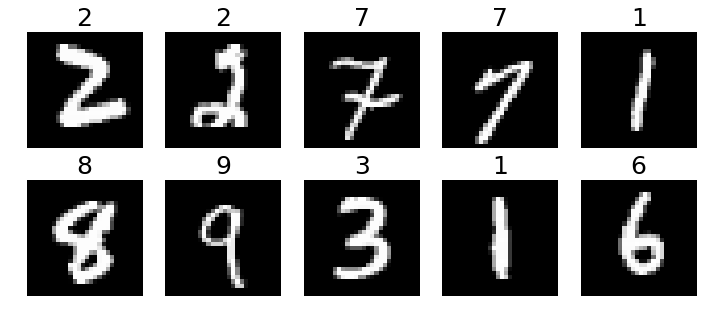

In [3]:
def save_submission(name, dataset, pred_labels):
    # Generating submission using pandas for grading
    submission = pd.DataFrame({'ImageId': range(1, len(dataset) + 1), 'Label': pred_labels })
    submission.to_csv(name, index = False)

def displayImages(data, label):
    fig, axes = plt.subplots(2,5, figsize=(12,5))
    axes = axes.flatten()

    xsize = data.shape[0]
    # Get random Variables
    idx = np.random.randint(0, xsize, size=10)
    for i in range(10):
        if (data.shape[1] == 784):
            axes[i].imshow(data[idx[i],:].reshape(28, 28), cmap='gray')
        else:
            axes[i].imshow(data[idx[i],: , :, :].reshape(28, 28), cmap='gray')

        axes[i].axis('off') # hide the axes ticks
        axes[i].set_title(str(int(label[idx[i]])), color= 'black', fontsize=25)
    plt.show()


displayImages(X_train, y_train)

Training: (41160, 784) (41160,)
Validation: (420, 784) (420,)
Testing: (420, 784) (420,)


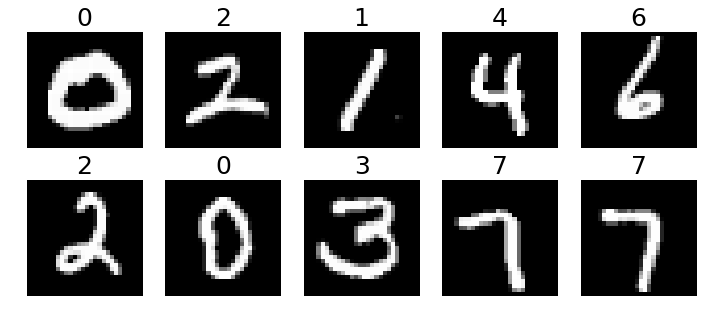

Training set (41160, 28, 28, 1) (41160, 10)
Validation set (420, 28, 28, 1) (420, 10)
Test set (420, 28, 28, 1) (420, 10)
Test set (28000, 28, 28, 1)


In [4]:
train = 0.98
train_size = int(X_train.shape[0]*train)
valid_size = int(X_train.shape[0]*(1.0 - train)/2.0)
test_size = int(X_train.shape[0]*(1.0 - train)/2.0)

# print("train_size: %0.d"%train_size)
# print("valid_size: %0.d"%valid_size)
# print("test_size: %0.d"%test_size)

def shuffle_data(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
# Mix all the data
shuffle_data(X_train, y_train)

# Get Train Data
start_t = 0
end_t = train_size
train_dataset = X_train[start_t:end_t,:]
train_labels = y_train[start_t:end_t]

# Get Validation Data
start_t = train_size
end_t = valid_size + train_size
valid_dataset = X_train[start_t:end_t,:]
valid_labels = y_train[start_t:end_t]

# Get Test Data
start_t = valid_size + train_size
end_t = valid_size + train_size + test_size
test_dataset = X_train[start_t:end_t,:]
test_labels = y_train[start_t:end_t]

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

# Check if they are still ok
displayImages(train_dataset, train_labels)

image_size = 28  # Pixel width and height.
num_labels = 10
num_channels = 1 # grayscale

#This part is different for Convolutional Neural Netowrks
def reformat(dataset, labels = None):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    if labels is not None:
        labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

X_test_public, _ = reformat(X_test_public)
print('Test set', X_test_public.shape)

In [5]:
def accuracy(predictions, labels):
    correct_prediction = np.argmax(predictions, 1) == np.argmax(labels, 1)
    accuracy = (100.0 * np.sum(correct_prediction) / predictions.shape[0])
    return accuracy

# Create image size function based on input, filter size, padding and stride
# 2 convolutions only
def output_size_no_pool(input_size, filter_size, padding, conv_stride):
    if padding == 'same':
        padding = -1.00
    elif padding == 'valid':
        padding = 0.00
    else:
        return None
    output_1 = float(((input_size - filter_size - 2*padding) / conv_stride) + 1.00)
    output_2 = float(((output_1 - filter_size - 2*padding) / conv_stride) + 1.00)
    return int(np.ceil(output_2))

patch_size = 5
final_image_size = output_size_no_pool(image_size, patch_size, padding='same', conv_stride=2)

In [81]:
batch_size = 16
patch_size = 5
# Depth is the number of output channels 
# On the other hand, num_channels is the number of input channels set at 1 previously
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')
        
    '''Model'''
    # Input channels: num_channels = 1
    # Output channels: depth = 16
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # Input channels: depth = 16
    # Output channels: depth = 16
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # Use neurons to allow processing of entire image
    final_image_size = output_size_no_pool(image_size, patch_size, padding='same', conv_stride=2)
    layer3_weights = tf.Variable(tf.truncated_normal([final_image_size * final_image_size * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    '''Model'''
    def model(data):
        # First Convolutional Layer
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)

        # Second Convolutional Layer
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)

        # Full Connected Layer
        shape = tf.shape(hidden)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

        # Readout Layer: Softmax Layer
        output = tf.matmul(hidden, layer4_weights) + layer4_biases

        return output
  
    '''Training computation'''
    logits = model(tf_train_dataset)
    soft = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits)
    loss = tf.reduce_mean(soft)

    '''Optimizer'''
    # Learning rate of 0.05
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    '''Predictions for the training, validation, and test data'''
    train_prediction = tf.nn.softmax(logits)

    vlogits = model(tf_valid_dataset)
    valid_prediction = tf.nn.softmax(vlogits)

    tlogits = model(tf_test_dataset)
    test_prediction = tf.nn.softmax(tlogits)

Initialized
Minibatch loss at step 0: 2.763793
Minibatch accuracy: 0.00%
Validation accuracy: 11.19%
=====================Finished!======================
Running time:  0.32s
Test accuracy: 10.00%


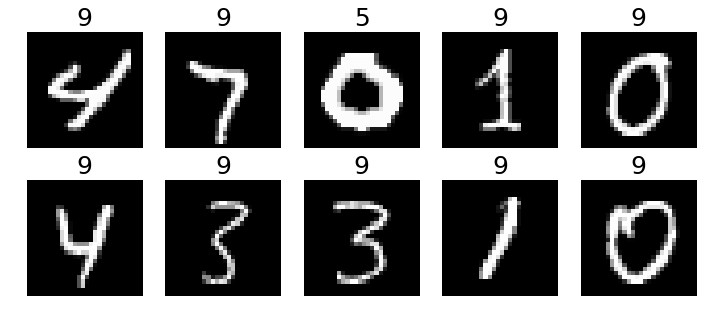

In [82]:
num_steps = 3000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    t = time.process_time()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 5000 == 0):
            print('===========================================')
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.2f%%' % accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels))

    elapsed_time = time.process_time() - t
    print('=====================Finished!======================')
    print('Running time:  %.2fs' % elapsed_time)
    print('Test accuracy: %.2f%%' % accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels))
    
    # Predict test Data
    pred_labels = test_prediction.eval({tf_test_dataset: X_test_public})
    pred_labels = np.argmax(pred_labels, 1)
    displayImages(X_test_public, pred_labels)

    # Save in CSV
    save_submission("simplemnist_tf_cnv_result.csv", X_test_public, pred_labels)

The best Result: 0.98142
----
-----------------------------------

Formats
* tf.nn.conv2d(input, filter, strides, padding)
* tf.nn.max_pool(value, ksize, strides, padding)

In [90]:
batch_size = 16
patch_size = 5
# Depth is the number of output channels 
# On the other hand, num_channels is the number of input channels set at 1 previously
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')
        
    '''Model'''
    # Input channels: num_channels = 1
    # Output channels: depth = 16
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # Input channels: depth = 16
    # Output channels: depth = 16
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # Use neurons to allow processing of entire image
    final_image_size = output_size_no_pool(image_size, patch_size, padding='same', conv_stride=2)
    layer3_weights = tf.Variable(tf.truncated_normal([final_image_size * final_image_size * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    '''Model'''
    def model(data):
        # First Convolutional Layer with Pooling
        conv_1 = tf.nn.conv2d(data, layer1_weights, strides=[1, 1, 1, 1], padding='SAME')
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases)
        pool_1 = tf.nn.max_pool(hidden_1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        # Second Convolutional Layer with Pooling
        conv_2 = tf.nn.conv2d(pool_1, layer2_weights, strides=[1, 1, 1, 1], padding='SAME')
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
        pool_2 = tf.nn.max_pool(hidden_2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        # Full Connected Layer
        shape = tf.shape(pool_2)
        reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

        # Readout Layer: Softmax Layer
        output = tf.matmul(hidden, layer4_weights) + layer4_biases

        return output
  
    '''Training computation'''
    logits = model(tf_train_dataset)
    soft = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits)
    loss = tf.reduce_mean(soft)

    '''Optimizer'''
    # Learning rate of 0.05
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    '''Predictions for the training, validation, and test data'''
    train_prediction = tf.nn.softmax(logits)

    vlogits = model(tf_valid_dataset)
    valid_prediction = tf.nn.softmax(vlogits)

    tlogits = model(tf_test_dataset)
    test_prediction = tf.nn.softmax(tlogits)

Initialized
Minibatch loss at step 0: 4.879535
Minibatch accuracy: 0.00%
Validation accuracy: 11.19%
Minibatch loss at step 5000: 0.150072
Minibatch accuracy: 93.75%
Validation accuracy: 97.62%
Minibatch loss at step 10000: 0.048403
Minibatch accuracy: 93.75%
Validation accuracy: 99.05%
Minibatch loss at step 15000: 0.018303
Minibatch accuracy: 100.00%
Validation accuracy: 98.57%
Minibatch loss at step 20000: 0.010441
Minibatch accuracy: 100.00%
Validation accuracy: 99.52%
Minibatch loss at step 25000: 0.000057
Minibatch accuracy: 100.00%
Validation accuracy: 98.10%
=====================Finished!======================
Running time:  459.09s
Test accuracy: 98.57%


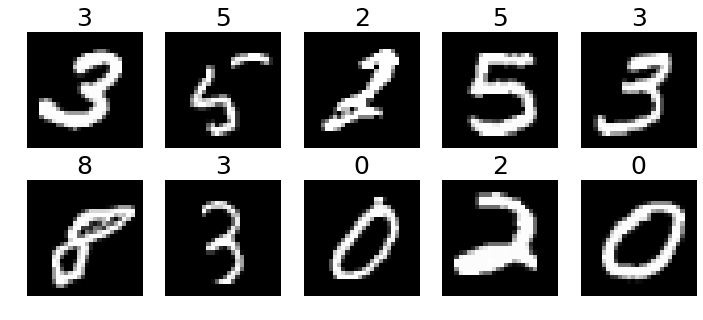

In [92]:
num_steps = 30000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    t = time.process_time()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 5000 == 0):
            print('===========================================')
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.2f%%' % accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels))

    elapsed_time = time.process_time() - t
    print('=====================Finished!======================')
    print('Running time:  %.2fs' % elapsed_time)
    print('Test accuracy: %.2f%%' % accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels))

    # Predict test Data
    pred_labels = test_prediction.eval({tf_test_dataset: X_test_public})
    pred_labels = np.argmax(pred_labels, 1)
    displayImages(X_test_public, pred_labels)

    # Save in CSV
    save_submission("simplemnist_tf_cnv_maxpool_result.csv", X_test_public, pred_labels)

---
LeNet5
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

Details

* image_size = 28
* Convolutions
    * conv_filter_size = 5
    * conv_stride = 1
* Average Pooling
    * pool_filter_size = 2
    * pool_stride = 2
* padding='valid'
* Prevent overfitting
    * Learning rate decay
    * Regularization
    * Dropout
* Layers
    * Convolution
    * Pooling
    * Convolution
    * Pooling
    * Fully-connected
    * Fully-connected
    * Readout

New function for Image Size: Pooling

In [6]:
image_size = 28
# Create image size function based on input, filter size, padding and stride
# 2 convolutions only with 2 pooling
def output_size_pool(input_size, conv_filter_size, pool_filter_size, padding, conv_stride, pool_stride):
    if padding == 'same':
        padding = -1.00
    elif padding == 'valid':
        padding = 0.00
    else:
        return None
    # After convolution 1
    output_1 = (((input_size - conv_filter_size - 2*padding) / conv_stride) + 1.00)
    # After pool 1
    output_2 = (((output_1 - pool_filter_size - 2*padding) / pool_stride) + 1.00)    
    # After convolution 2
    output_3 = (((output_2 - conv_filter_size - 2*padding) / conv_stride) + 1.00)
    # After pool 2
    output_4 = (((output_3 - pool_filter_size - 2*padding) / pool_stride) + 1.00)  
    return int(output_4)

final_image_size = output_size_pool(input_size=image_size, conv_filter_size=5, pool_filter_size=2, padding='valid', conv_stride=1, pool_stride=2)

In [7]:
batch_size = 16
# Depth is the number of output channels 
# On the other hand, num_channels is the number of input channels set at 1 previously
depth = 32
num_hidden = 64
beta = 0.001

graph = tf.Graph()

with graph.as_default():
    '''Input data'''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name = 'y-input')
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')
    tf_test_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels), name = 'x-input')

    '''Variables'''
    # Convolution 1 Layer
    # Input channels: num_channels = 1
    # Output channels: depth = 16
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # Convolution 2 Layer
    # Input channels: depth = 16
    # Output channels: depth = 16
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # First Fully Connected Layer (Densely Connected Layer)
    # Use neurons to allow processing of entire image
    final_image_size = output_size_pool(input_size=image_size, conv_filter_size=5, pool_filter_size=2, padding='valid', conv_stride=1, pool_stride=2)
    layer3_weights = tf.Variable(tf.truncated_normal([final_image_size * final_image_size * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # Second Fully Connected Layer
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_hidden], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # Readout layer: Softmax Layer
    layer5_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    '''Model'''
    def model(data):
        # First Convolutional Layer with Pooling
        conv_1 = tf.nn.conv2d(data, layer1_weights, strides=[1, 1, 1, 1], padding='VALID')
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases)
        pool_1 = tf.nn.avg_pool(hidden_1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # Second Convolutional Layer with Pooling
        conv_2 = tf.nn.conv2d(pool_1, layer2_weights, strides=[1, 1, 1, 1], padding='VALID')
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
        pool_2 = tf.nn.avg_pool(hidden_2, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # First Fully Connected Layer
        shape = tf.shape(pool_2)
        reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        keep_prob = 0.5
        hidden_drop = tf.nn.dropout(hidden, rate = 1.0 - keep_prob)
        
        # Second Fully Connected Layer
        hidden_2 = tf.nn.relu(tf.matmul(hidden_drop, layer4_weights) + layer4_biases)
        hidden_2_drop = tf.nn.dropout(hidden_2, rate = 1.0 - keep_prob)
        
        # Readout Layer: Softmax Layer
        return tf.matmul(hidden_2_drop, layer5_weights) + layer5_biases

    '''Training computation'''
    logits = model(tf_train_dataset)
    soft = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits)
    loss = tf.reduce_mean(soft)
    
    # Loss function with L2 Regularization 
    # regularizers = tf.nn.l2_loss(layer4_weights) + \
                   # tf.nn.l2_loss(layer5_weights)
    # loss = tf.reduce_mean(loss + beta * regularizers)

    '''Optimizer'''
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    '''Predictions for the training, validation, and test data'''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Instructions for updating:
Colocations handled automatically by placer.


Initialized
Minibatch loss at step 0: 4.314141
Minibatch accuracy: 6.25%
Validation accuracy: 10.24%
Minibatch loss at step 5000: 0.153779
Minibatch accuracy: 93.75%
Validation accuracy: 94.76%
Minibatch loss at step 10000: 0.088522
Minibatch accuracy: 93.75%
Validation accuracy: 95.00%
Minibatch loss at step 15000: 0.019232
Minibatch accuracy: 100.00%
Validation accuracy: 96.43%
Minibatch loss at step 20000: 0.131499
Minibatch accuracy: 93.75%
Validation accuracy: 97.38%
Minibatch loss at step 25000: 0.001942
Minibatch accuracy: 100.00%
Validation accuracy: 97.62%
Minibatch loss at step 30000: 0.001024
Minibatch accuracy: 100.00%
Validation accuracy: 97.86%
=====================Finished!======================
Running time:  624.07s
Test accuracy: 97.14%


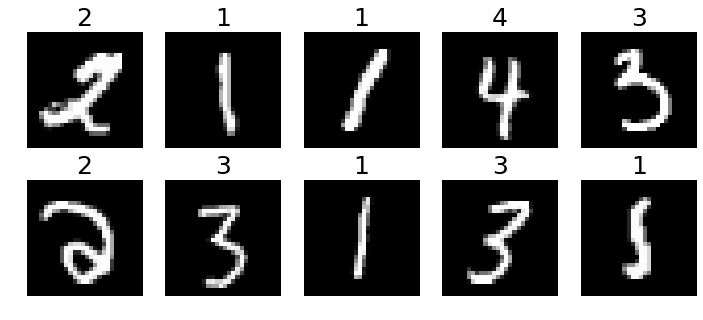

In [8]:
num_steps = 30001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    t = time.process_time()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 5000 == 0):
            print('===========================================')
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.2f%%' % accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset}), valid_labels))

    elapsed_time = time.process_time() - t
    print('=====================Finished!======================')
    print('Running time:  %.2fs' % elapsed_time)
    print('Test accuracy: %.2f%%' % accuracy(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels))
    
    # Predict test Data
    pred_labels = test_prediction.eval({tf_test_dataset: X_test_public})
    pred_labels = np.argmax(pred_labels, 1)
    displayImages(X_test_public, pred_labels)

    # Save in CSV
    save_submission("simplemnist_tf_LeNet_result.csv", X_test_public, pred_labels)